# Assessment 01

will be using the Constraint satisfaction problem algo (CSP)

In [69]:
%pip install python-constraint
%pip install matplotlib

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/pip/__main__.py", line 8, in <module>
    if sys.path[0] in ("", os.getcwd()):
                           ^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory
Note: you may need to restart the kernel to use updated packages.
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/pip/__main__.py", line 8, in <module>
    if sys.path[0] in ("", os.getcwd()):
                           ^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory
Note: you may need to restart the kernel to use updated packages.


In [70]:
from time import time
import random
import logging

from constraint import Problem
import matplotlib.pyplot as plt

Define the file to use as dataSet

### Data structures definition for parsed data

In [71]:
class GeneralInformation:
    def __init__(
        self,
        projects,
        jobs,
        horizon,
        renewable_resources,
        nonrenewable_resources,
        doubly_constrained_resources,
    ):
        self.projects = projects
        self.jobs = jobs
        self.horizon = horizon
        self.resources = {
            "renewable": renewable_resources,
            "nonrenewable": nonrenewable_resources,
            "doubly_constrained": doubly_constrained_resources,
        }

In [72]:
class ProjectSummary:
    def __init__(
        self, project_number, jobs, release_date, due_date, tardiness_cost, mpm_time
    ):
        self.project_number = project_number
        self.jobs = jobs
        self.release_date = release_date
        self.due_date = due_date
        self.tardiness_cost = tardiness_cost
        self.mpm_time = mpm_time

In [73]:
class Job:
    def __init__(self, job_number, successors):
        self.job_number = job_number
        self.successors = successors

In [74]:
class DurationResource:
    def __init__(self, job_number, mode, duration, resources):
        self.job_number = job_number
        self.mode = mode
        self.duration = duration
        self.resources = resources

In [75]:
class ResourceAvailability:
    def __init__(self, resource_name, quantity):
        self.resource_name = resource_name
        self.quantity = quantity


In [76]:
class ProjectData:
    def __init__(self):
        self.general_info: GeneralInformation = None
        self.projects_summary: list[ProjectSummary] = []
        self.precedence_relations: list[Job] = []
        self.durations_resources: list[DurationResource] = []
        self.resource_availability: dict[str, ResourceAvailability] = {}

## Data parsing function

In [77]:
def parse_file(file) -> ProjectData:
    data = ProjectData()
    # Track the file section
    section = None

    for line in file:
        line = line.strip()

        # Skip ornament and invalid
        if line.startswith("**") or not line:
            continue

        if line.startswith("#"):
            # Match the file section
            match line:
                case "#General Information":
                    section = "general_info"
                    continue
                case "#Projects summary":
                    section = "projects_summary"
                    continue
                case "#Precedence relations":
                    section = "precedence_relations"
                    continue
                case "#Duration and resources":
                    section = "durations_resources"
                    continue
                case "#Resource availability":
                    section = "resource_availability"
                    continue

        match section:
            case "general_info":
                if "projects" in line:
                    data.general_info = GeneralInformation(
                        int(line.split(":")[1].strip()),
                        jobs=0,
                        horizon=0,
                        renewable_resources=0,
                        nonrenewable_resources=0,
                        doubly_constrained_resources=0,
                    )
                elif "jobs" in line:
                    data.general_info.jobs = int(line.split(":")[1].strip())
                elif "horizon" in line:
                    data.general_info.horizon = int(line.split(":")[1].strip())
                elif line.startswith("- renewable"):
                    data.general_info.resources["renewable"] = int(
                        line.split(":")[1].split()[0].strip()
                    )
                elif line.startswith("- nonrenewable"):
                    data.general_info.resources["nonrenewable"] = int(
                        line.split(":")[1].split()[0].strip()
                    )
                elif line.startswith("- doubly constrained"):
                    data.general_info.resources["doubly_constrained"] = int(
                        line.split(":")[1].split()[0].strip()
                    )

            case "projects_summary":
                # Skip header line
                if line.startswith("pronr."):
                    continue

                splits = line.split()
                if splits:
                    data.projects_summary.append(
                        ProjectSummary(
                            project_number=int(splits[0]),
                            jobs=int(splits[1]),
                            release_date=int(splits[2]),
                            due_date=int(splits[3]),
                            tardiness_cost=int(splits[4]),
                            mpm_time=int(splits[5]),
                        )
                    )

            case "precedence_relations":
                # Skip header line
                if line.startswith("#jobnr."):
                    continue

                splits = line.split()
                if splits:
                    data.precedence_relations.append(
                        Job(
                            job_number=int(splits[0]),
                            successors=list(map(int, splits[3:])),
                        )
                    )

            case "durations_resources":
                # Skip header line
                if line.startswith("#jobnr."):
                    continue

                splits = line.split()
                if splits:
                    resourcesData = {}
                    for i in range(len(splits) - 3):
                        resourcesData[f"R{i+1}"] = int(splits[i + 3])

                    data.durations_resources.append(
                        DurationResource(
                            job_number=int(splits[0]),
                            mode=int(splits[1]),
                            duration=int(splits[2]),
                            resources=resourcesData,
                        )
                    )

            case "resource_availability":
                # Skip header line
                if line.startswith("#resource"):
                    continue

                splits = line.split()
                if splits:
                    name = splits[0]

                    data.resource_availability[name] = ResourceAvailability(
                        resource_name=name, quantity=int(splits[1])
                    )

    return data


# Defining the solver

### Problem BreakDown

- Variables: Each job can be seen as a variable. The value of this variable will be the start time of that job.
- Domains: The domain for each job variable will be the possible start times, considering the project’s time horizon.
- Constraints:
	- Precedence Constraints: A job cannot start before its predecessors are finished (if job A precedes job B, then job A’s end time must be before job B starts).
	- Resource Constraints: The number of resources (e.g., designers, programmers) is limited. So, at any given time, the total resources used by all jobs must not exceed the available resources.
	- Duration Constraints: Each job has a specific duration, so its end time is determined by its start time and duration.

In [78]:
def successor_constraint(start_job: int, start_successor: int, duration: int):
    return start_job + duration <= start_successor

In [79]:
def resource_constraint(*start_times, time_slots, project_data: ProjectData):
    resource_usage = {
        resource: [0] * len(time_slots)
        for resource in project_data.resource_availability.keys()
    }

    # Update resources only for active times
    for job_index, start_time in enumerate(start_times):
        job_data = project_data.durations_resources[job_index]
        end_time = start_time + job_data.duration

        # Mark the resources used in the relevant time slots
        for t in range(start_time, end_time):
            if t >= len(time_slots):
                break  # Stay within time slots

            for resource, amount in job_data.resources.items():
                resource_usage[resource][t] += amount

    # Check if resources exceed availability
    for t in range(len(time_slots)):
        for resource, usage in resource_usage.items():
            if usage[t] > project_data.resource_availability[resource].quantity:
                return False  # Constraint violated

    return True

In [80]:
def due_date_constraint(*start_times, project_data: ProjectData):
    durations = [dr.duration for dr in project_data.durations_resources]
    due_date = project_data.projects_summary[0].due_date

    # Identify all sink jobs (jobs with no successors)
    sink_jobs = []
    for i, job in enumerate(project_data.precedence_relations):
        if not job.successors:  # Job with no successors
            sink_jobs.append(i)

    if not sink_jobs:
        raise ValueError("No sink jobs found in precedence relations!")

    # Compute the completion times of all sink jobs
    latest_completion_time = 0
    for sink_job_index in sink_jobs:
        sink_job_start_time = start_times[sink_job_index]
        sink_job_duration = durations[sink_job_index]
        sink_job_completion_time = sink_job_start_time + sink_job_duration

        # Track the latest completion time
        latest_completion_time = max(latest_completion_time, sink_job_completion_time)

    # Ensure the latest completion time respects the due date
    return latest_completion_time <= due_date


In [81]:
def define_problem(data: ProjectData) -> Problem:
    longestProject = max(
        data.projects_summary, key=lambda summary: summary.due_date
    ).due_date

    domain = range(longestProject + 1)
    start_times = [f"job_{job.job_number}" for job in data.precedence_relations]

    problem = Problem()

    # Define variables for each job, and the domain are the available time on the horizon (20 days)
    for job in data.precedence_relations:
        number = job.job_number
        var_name = f"job_{number}"

        problem.addVariable(var_name, domain)

        for successor in job.successors:
            duration = data.durations_resources[number - 1].duration

            problem.addConstraint(
                lambda start_j, start_s, duration=duration: successor_constraint(
                    start_j, start_s, duration
                ),
                (f"job_{number}", f"job_{successor}"),
            )

    problem.addConstraint(
        lambda *start_times: resource_constraint(
            *start_times, time_slots=domain, project_data=data
        ),
        start_times,
    )

    return problem

# Utils
Used as soft constraints
Processing the results to remove the unnecessary offsets

In [82]:
def process_solution(solution, pData: ProjectData):
    has_preced = set()

    for job in pData.precedence_relations:
        for pId in job.successors:
            has_preced.add(f"job_{pId}")

    min_offset = min(solution[key] for key in solution if key not in has_preced)

    for key in solution:
        solution[key] -= min_offset

    return solution


# Visualization

In [83]:
def random_color():
    return "#{:02x}{:02x}{:02x}".format(
        random.randint(0, 255),
        random.randint(0, 255),
        random.randint(0, 255)
    )

# Data: start days and durations
# Prepare data for the Gantt chart
def draw_solution(solution, pData: ProjectData, file_path: str):
    job_names = list(solution.keys())
    start_day = list(solution.values())

    duration = [pData.durations_resources[int(job.split('_')[1]) - 1].duration for job in job_names]

    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(10, 6))

    # Generate a list of random colors
    colors = [random_color() for _ in job_names]

    # Horizontal bars
    ax.barh(job_names, duration, left=start_day, color=colors, edgecolor='black')

    # Add labels and grid
    ax.set_xlabel('Days')
    ax.set_ylabel('Jobs')
    ax.set_title(f'Job Schedule ({file_path})')
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    # Annotate each job bar with its duration
    for i, job in enumerate(job_names):
        ax.text(start_day[i] + duration[i] / 2, i, f'{duration[i]} days', ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

In [84]:
def plot_resource_usage(solution, project_data: ProjectData, file_path: str):
    horizon = max(value for  value in solution.values()) + 1
    # Initialize resource usage dynamically
    resource_usage = {
        resource: [0] * horizon for resource in project_data.resource_availability.keys()
    }


    # Compute resource usage
    for job_index, start_time in solution.items():
        job_number = int(job_index.split('_')[1]) - 1
        job_data = project_data.durations_resources[job_number]
        end_time = start_time + job_data.duration

        # Update resource usage for the duration of the job
        for t in range(start_time, end_time):
            if t < horizon:  # Stay within the horizon
                for resource, amount in job_data.resources.items():
                    resource_usage[resource][t] += amount

    # Plot the resource usage
    time_slots = range(horizon)
    plt.figure(figsize=(10, 6))

    for resource, usage in resource_usage.items():
        # Plot resource usage
        plt.plot(time_slots, usage, label=f"Resource {resource}", marker="o")

        # Plot resource availability as a horizontal line
        plt.axhline(
            y=project_data.resource_availability[resource].quantity,
            linestyle="--",
            label=f"{resource} Availability"
        )

    # Add labels, legend, and title
    plt.xlabel("Time (Days)")
    plt.ylabel("Resource Usage")
    plt.title(f"Resource Occupation Over Time ({file_path})")
    plt.legend()
    plt.grid()

    plt.xticks(range(horizon))  

    # Show the plot
    plt.show()

# Main

INFO:root: Solution found : 0.0971 seconds
INFO:root: Processing time: 0.0006 seconds


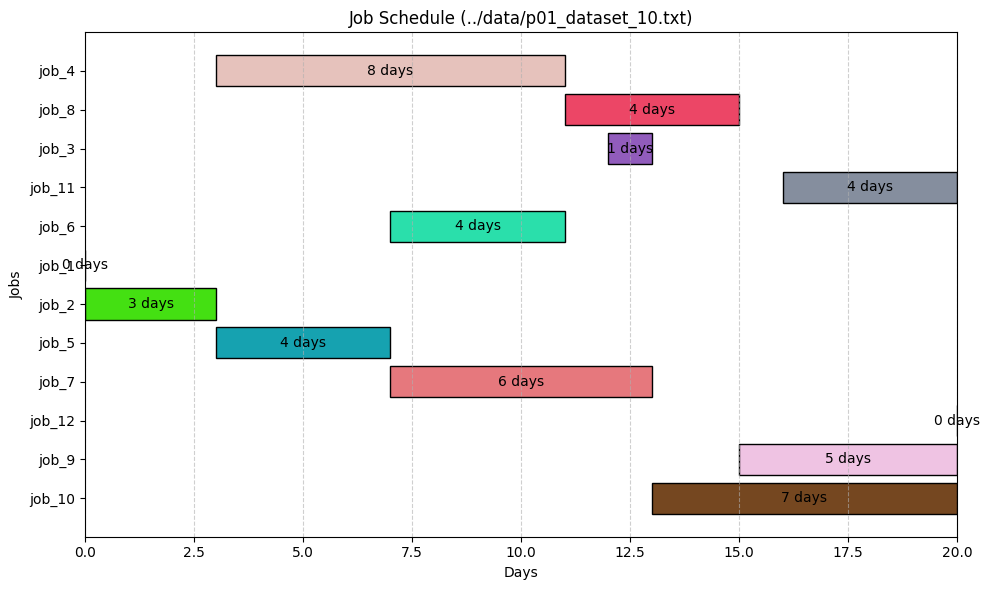

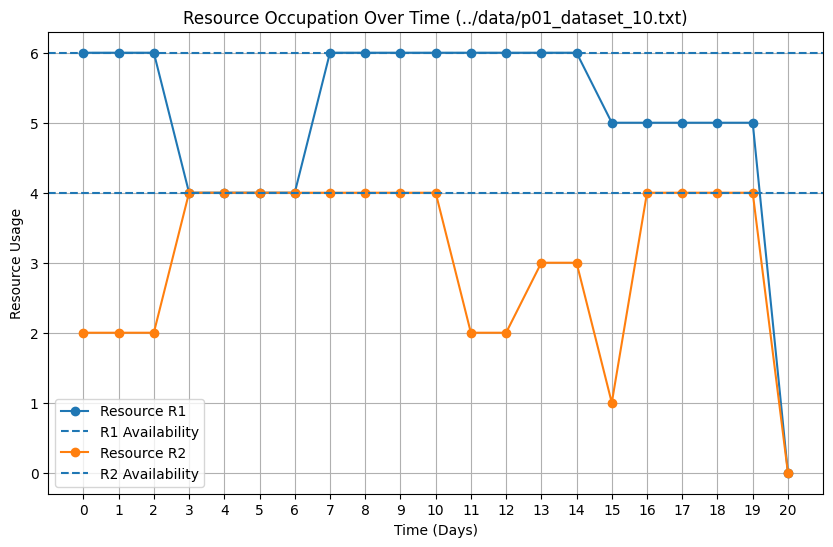

INFO:root: Processing time: 0.3706 seconds
INFO:root: Execution time: 0.4688 seconds


In [101]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

start_time = time()
# Modify this path to the correct dataSet location
file_path :str = "../data/p01_dataset_10.txt"
try:
	with open(file_path, "r") as file:
			proj_data: ProjectData = parse_file(file)
			problem = define_problem(proj_data)
			solution = problem.getSolution()
			
			get_solution_time = time()
			logging.info(
					f" Solution found : {(get_solution_time - start_time):.4f} seconds"
			)

			if solution:
				solution = process_solution(solution=solution, pData=proj_data)
				
				processed_solution_time = time()
				logging.info(
					f" Processing time: {(time() - get_solution_time):.4f} seconds"
				)

				draw_solution(solution, proj_data, file_path)
				plot_resource_usage(solution, proj_data, file_path)
				
				logging.info(
					f" Processing time: {(time() - processed_solution_time):.4f} seconds"
				)
				
except:
	logging.error("File not found: %s", file_path)


end_time = time()
logging.info(f" Execution time: {(end_time - start_time):.4f} seconds")
